In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

For this notebook, you will need `theano` and `emcee`. You can install them with `conda install theano` and `pip install emcee` (as the latter one is not available in anaconda)

In [3]:
import theano
import theano.tensor as T

Generating data
=========

This part is exactly as before

In [4]:
def logistic_p(xs, beta0, beta1):
    """calculate probabilities p(y=1|x) for beta0 and beta1
    """
    p_y_data = 1/(1+np.exp(beta0+beta1*xs))
    return p_y_data

def logistic_samples(xs, beta0, beta1):
    """sample from p(y|x)"""
    p_y_data = logistic_p(xs, beta0, beta1)
    y_data = np.random.uniform(size=len(xs)) < p_y_data
    y_data = y_data.astype(np.float)
    return y_data

In [5]:
x_data = np.random.uniform(size=30)
y_data = logistic_samples(x_data, 4.6, -5.9)

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


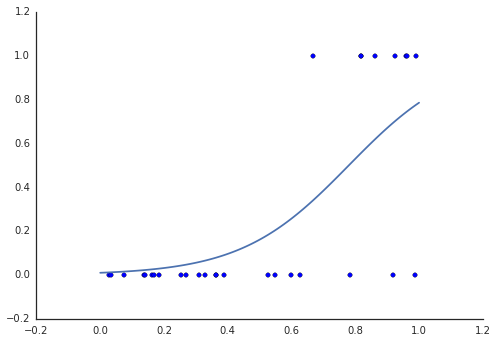

In [6]:
plt.scatter(x_data, y_data)
xs = np.linspace(0,1, num=100)
ys = logistic_p(xs, 4.6, -5.9)
plt.plot(xs, ys)
sns.despine()

Optimizing
======

Now we use theano to calculate the function and the gradient

In [7]:
from scipy.optimize import minimize

In [8]:
x_data_theano = T.vector('x_data') # These are now symbols, not data
y_data_theano = T.vector('y_data')
beta0_theano = T.scalar('beta0')
beta1_theano = T.scalar('beta1')

p_1 = 1 / (1 + T.exp(beta0_theano + beta1_theano*x_data_theano)) 
p_0 = 1 - p_1

cost = -T.mean((y_data_theano*T.log(p_1) + (1-y_data_theano)*T.log(p_0)))
#cost = -1.0/y_data.shape[0]*(T.dot(y_data_theano,T.log(p_1)) + T.dot((1-y_data_theano), T.log(p_0)))

# let theano calculate the graph for the gradients
d_cost_beta0 = T.grad(cost, beta0_theano)
d_cost_beta1 = T.grad(cost, beta1_theano)

# put everything into a function compiled in c (or cuda).
cost_and_gradient_theano = theano.function([x_data_theano, y_data_theano, beta0_theano, beta1_theano],  # input
                                           [cost, d_cost_beta0, d_cost_beta1],  # output
                                          )

In [9]:
# wrap function around to be compatible with scipy.optimize.minimize
def f(theta, x_data, y_data):
    cost, d_beta0, d_beta1 = cost_and_gradient_theano(x_data, y_data, theta[0], theta[1])
    return cost, np.array([d_beta0, d_beta1])

In [10]:
# Starting point
theta0 = np.array([0, 0])

# Do the optimization
res = minimize(f, theta0, jac=True, method='BFGS', tol=1e-10, args=(x_data, y_data))

print(res)

      nit: 19
      fun: 0.28323817254214595
   status: 0
     nfev: 20
  success: True
        x: array([ 6.9763601 , -8.80040674])
      jac: array([  2.81412532e-11,   4.90058584e-11])
  message: 'Optimization terminated successfully.'
 hess_inv: array([[ 230.52173016, -278.19854712],
       [-278.19854712,  352.84027383]])
     njev: 20


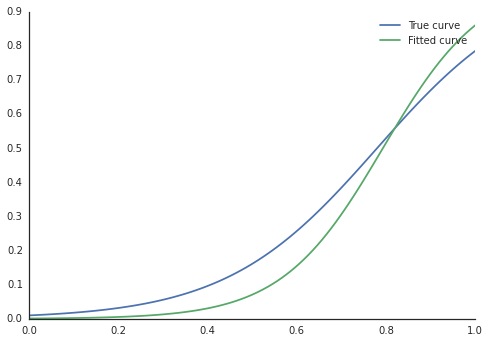

In [11]:
xs = np.linspace(0, 1,  num=100)
p_true = logistic_p(xs, 4.6, -5.9)
p_fit = logistic_p(xs, res.x[0], res.x[1])

plt.plot(xs, p_true, label="True curve")
plt.plot(xs, p_fit, label="Fitted curve")
plt.legend()
sns.despine()

In [12]:
cost_and_gradient_theano(x_data, y_data, 100, -100)

[array(3.351204721092075),
 array(0.24908869897860175),
 array(0.21601420406406802)]

Baysian inference using Emcee
======

In [13]:
import emcee
import pandas as pd

In [41]:
lnlike_theano = T.sum((y_data_theano*T.log(p_1) + (1-y_data_theano)*T.log(p_0)))

In [44]:
lnlike_theano_function = theano.function([x_data_theano, y_data_theano, beta0_theano, beta1_theano], lnlike_theano)

def lnlike(theta, xs, ys):
    return lnlike_theano_function(xs, ys, theta[0], theta[1])

def lnprior(theta, xs, ys):
    # proportional to gaussian, std 10
    var = 10**2
    return -np.square(theta).sum() / var / 2.0

def lnprob(theta, xs, ys):
    lp = lnprior(theta, xs, ys)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, xs, ys)

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


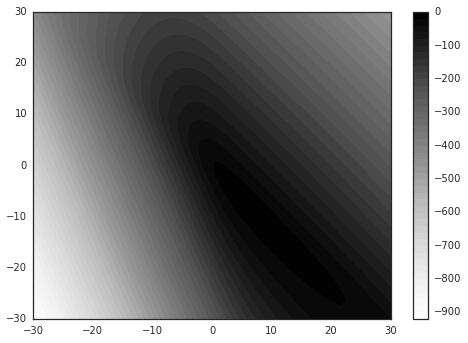

In [45]:
# np.vectorize
lnprob_vectorized = np.vectorize(lambda beta0, beta1: lnprob(np.asarray([beta0, beta1]), x_data, y_data))

beta0s = np.linspace(-30, 30)
beta1s = np.linspace(-30, 30)
Beta0s, Beta1s = np.meshgrid(beta0s, beta1s)
lnprob_grid = lnprob_vectorized(Beta0s, Beta1s)

plt.contourf(Beta0s, Beta1s, lnprob_grid, 50)
plt.colorbar();

In [66]:
ndim, nwalkers = 2, 10
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[x_data, y_data])
pos, prob, state = sampler.run_mcmc(p0, 100) # Burnin
sampler.reset()
sampler.run_mcmc(pos, 1000);

In [67]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.702


In [68]:
df = pd.DataFrame(sampler.flatchain, columns=['beta0', 'beta1'])

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


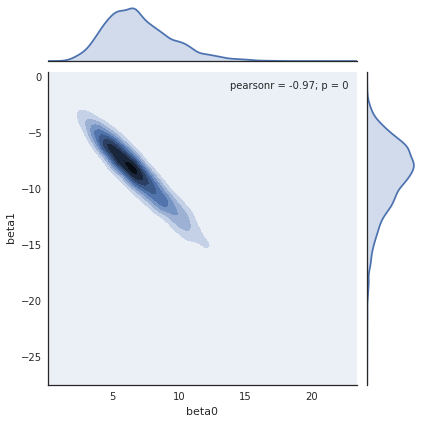

In [69]:
sns.jointplot('beta0', 'beta1', data=df, kind='kde')

In [70]:
def confidence_interval(data, size = 0.95):
    tail = (1.0-size) / 2
    lower = np.percentile(data, tail*100)
    higher = np.percentile(data, 100-tail*100)
    return lower, higher

In [71]:
print("Beta0: ", confidence_interval(df.beta0))
print("Beta1: ", confidence_interval(df.beta1))

Beta0:  (3.0469401995488137, 12.785647984266916)
Beta1:  (-15.93548314481191, -3.8096933160108519)


In [72]:
# Inference wiht more data
x_data_large = np.random.uniform(size=10000)
y_data_large = logistic_samples(x_data_large, 4.6, -5.9)

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


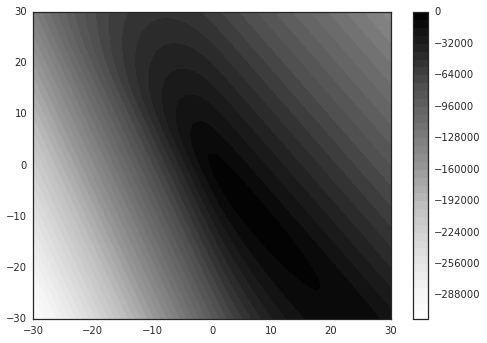

In [65]:
lnprob_vectorized = np.vectorize(lambda beta0, beta1: lnprob(np.asarray([beta0, beta1]), x_data_large, y_data_large))
beta0s = np.linspace(-30, 30)
beta1s = np.linspace(-30, 30)
Beta0s, Beta1s = np.meshgrid(beta0s, beta1s)
lnprob_grid = lnprob_vectorized(Beta0s, Beta1s)
plt.contourf(Beta0s, Beta1s, lnprob_grid, 50)
plt.colorbar();

In [73]:
ndim, nwalkers = 2, 10
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[x_data_large, y_data_large])
pos, prob, state = sampler.run_mcmc(p0, 100) # Burnin
sampler.reset()
sampler.run_mcmc(pos, 1000);

df = pd.DataFrame(sampler.flatchain, columns=['beta0', 'beta1'])
#g = sns.PairGrid(df)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=15);

In [74]:
print("Beta0:", confidence_interval(df.beta0))
print("Beta1: ", confidence_interval(df.beta1))

Beta0: (4.3417202063586897, 4.72322890337235)
Beta1:  (-6.0433075068983451, -5.5150724256822761)


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


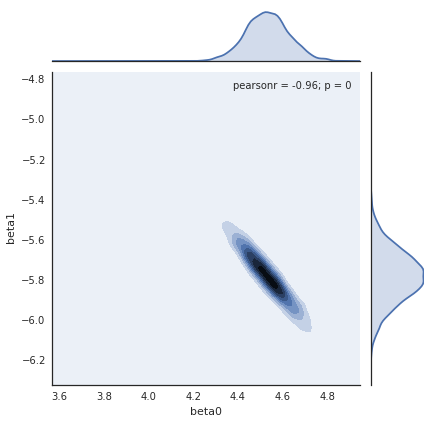

In [77]:
sns.jointplot('beta0', 'beta1', data=df, kind='kde')